In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.optimize import fsolve

sn.set_style('whitegrid')
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
# Expanded and modified version (first column now string)
def read_table(filename,keyword='ciclo',rescale=1,ncols=5,start=2,end_row='Total',
               endword=None,omit_list=['t20_21'],index_to_int=True,debug=False):
    t0 = start
    t1 = ncols+start
    results_follow = 0
    row_names = []
    f = open(filename,'r')
    for line in f:
        words = line.split()
        if debug:
            print(words)
        if len(words)>1 and words[0] == keyword:
            results_follow=1
            if endword==None:
                colnames = words[t0:t1]
            else:
                buff_v = []
                for w in words[t0:]:
                    if w==endword:
                        break
                    else:
                        buff_v.append(w)
                colnames = buff_v[:-1]
                t1 = len(buff_v)+t0-1
            table_raw = np.empty(t1-t0)
        elif len(words)>1 and words[0] == end_row:
            break
        elif len(words)>1 and results_follow==1 and words[0] not in omit_list:
            row_names.append(words[0])
            buff_v = []
            for w in words[t0:t1]: 
                w = w.replace(",","")
                buff_v.append(w)
            table_raw = np.vstack((table_raw,np.array(buff_v,dtype=float)/rescale))
    table_raw = table_raw[1:,:]
    if debug:
        print(table_raw.shape)
        print(colnames)
    if index_to_int:
        return pd.DataFrame(table_raw, columns=colnames,index=np.array(row_names,dtype=int))
    else:
        return pd.DataFrame(table_raw, columns=colnames,index=np.array(row_names))
    
    
def file_split(filename,path,startwords=['Summary',],endword="Total",header=None):
    f = open(path+filename,'r')
    parent_file = filename[:filename.find('.')]
    di = 1
    writing = 0
    for line in f:
        words = line.split()
        if len(words)>0 and words[0] in startwords:
            sf = open(path+parent_file+'_{}.log'.format(di), "w")
            writing = 1
            if header!=None:
                sf.write(header)
        elif len(words)>0 and words[0]==endword and writing:
            sf.write(line)
            writing = 0
            sf.close()
            di+=1
        if writing:
            sf.write(line)
            
def normalise_table(table):
    cols = table.columns
    table['Total'] = table.sum(axis=1).copy()
    for col in cols:
        table[col] = table[col]/table['Total']
    return table

In [94]:
dates = []
for year in range(1987,2023):
    for quarter in range(1,5):
        dates.append(str(year)+"Q"+str(quarter))
dates = dates[1:]

t0 = 59
t05 = 71
T = len(dates)
date_dict = dict(zip(range(t0,T+t0),dates))
date_dict_reverse = dict(zip(dates,range(0,T)))
date_dict_reverse_ciclo = dict(zip(dates,range(t0,T+t0)))

In [80]:
industry_dict = {"0": "agriculture", "1" :"manufactures, primary", "2": "extractive and energy", "3": "manufactures, secondary",
                 "4": "construction", "5": "hospitality and sales", "6": "Transport, storage and IT.",
                 "7": "Financial and prof. serv.", "8": "Education and healthcare", "9": "Other services"}

In [81]:
path = 'descriptive_stats/'

file_split('stocks_E_industry_w.log',path,startwords=['ciclo',],endword="Total",header=None)



In [95]:
tab_e_ind_1 = read_table(path+'stocks_E_industry_w_1.log',keyword='ciclo',rescale=100,ncols=6)
tab_e_ind_2 = read_table(path+'stocks_E_industry_w_2.log',keyword='ciclo',rescale=100,ncols=4)
tab_e_ind = pd.concat((tab_e_ind_1,tab_e_ind_2),axis=1)
tab_e_ind.rename(columns=industry_dict,inplace=True)
tab_e_ind.rename(index=date_dict,inplace=True)
tab_e_ind.head()

,agriculture,"manufactures, primary",extractive and energy,"manufactures, secondary",construction,hospitality and sales,"Transport, storage and IT.",Financial and prof. serv.,Education and healthcare,Other services
2005Q1,473715.07,994533.00,1035476.59,839644.48,1814072.71,2915322.75,891234.56,1673224.13,3301773.86,1272331.89
2005Q2,499959.89,1007007.37,1051515.39,846258.53,1875225.69,3067829.12,893954.68,1785085.40,3348945.49,1313956.69
2005Q3,506896.23,1006269.15,1076158.88,870718.23,1920187.68,3143106.60,920963.75,1794988.45,3355164.74,1374849.44
2005Q4,525850.30,1009786.14,1086961.30,824566.82,1939860.91,3144373.66,908474.94,1847232.28,3409273.70,1328851.90
2006Q1,508519.95,969445.08,1088810.74,849166.47,1947958.32,3102377.87,913945.53,1874000.16,3435714.02,1378562.25


In [96]:
av_19 = np.average(tab_e_ind.loc['2019Q1':'2019Q4',:].values,axis=0)
diff = tab_e_ind.iloc[1:,:].values-tab_e_ind.iloc[:-1,:].values
diff_19 = tab_e_ind.iloc[:,:].values-av_19

tab_e_ind_change = pd.DataFrame(diff,columns=tab_e_ind.keys(),index=tab_e_ind.index[1:])
tab_e_ind_change_rel = pd.DataFrame(diff/tab_e_ind.iloc[:-1,:].values,columns=tab_e_ind.keys(),index=tab_e_ind.index[1:])

tab_e_ind_change19 = pd.DataFrame(diff_19,columns=tab_e_ind.keys(),index=tab_e_ind.index[:])
tab_e_ind_change19_rel = pd.DataFrame(diff_19/av_19,columns=tab_e_ind.keys(),index=tab_e_ind.index[:])

tab_e_ind_change19_rel

,agriculture,"manufactures, primary",extractive and energy,"manufactures, secondary",construction,hospitality and sales,"Transport, storage and IT.",Financial and prof. serv.,Education and healthcare,Other services
2005Q1,-0.041172,0.257779,0.065548,0.099594,0.917041,-0.224023,-0.364629,-0.198323,-0.215100,0.017319
2005Q2,0.011949,0.273555,0.082052,0.108256,0.981665,-0.183430,-0.362689,-0.144728,-0.203886,0.050601
2005Q3,0.025988,0.272621,0.107412,0.140288,1.029179,-0.163393,-0.343434,-0.139984,-0.202408,0.099289
2005Q4,0.064352,0.277069,0.118528,0.079849,1.049969,-0.163056,-0.352338,-0.114953,-0.189545,0.062511
2006Q1,0.029275,0.226050,0.120431,0.112064,1.058526,-0.174234,-0.348438,-0.102127,-0.183260,0.102258
...,...,...,...,...,...,...,...,...,...,...
2021Q4,0.089617,-0.038452,0.023193,-0.019838,0.001760,-0.066078,0.095462,0.085598,0.082063,-0.102939
2022Q1,0.089721,-0.036982,-0.000862,-0.051066,0.020677,-0.074516,0.112097,0.056827,0.081956,-0.061978
2022Q2,0.018484,0.013726,0.038660,-0.055082,0.035776,-0.011973,0.120406,0.052527,0.093828,-0.035341
2022Q3,-0.108081,0.010440,0.034359,-0.006120,0.040459,0.004478,0.146028,0.071942,0.090265,-0.032557


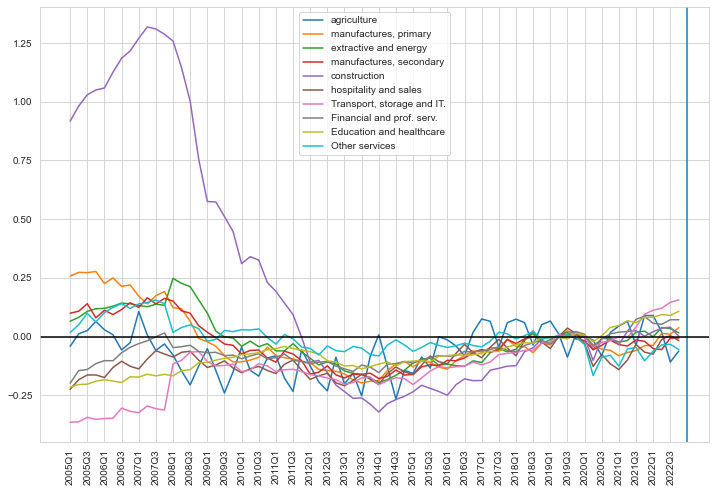

In [114]:
sn.set_palette('tab10',10)
plt.figure(figsize=(12,8))
for ind in industry_dict.values():
    plt.plot(tab_e_ind_change19_rel[ind],label=ind)
plt.legend()
plt.axvline('2020Q')
plt.axhline(c='k')
plt.xticks(tab_e_ind_change19_rel.index[::2],rotation=90)
plt.show()

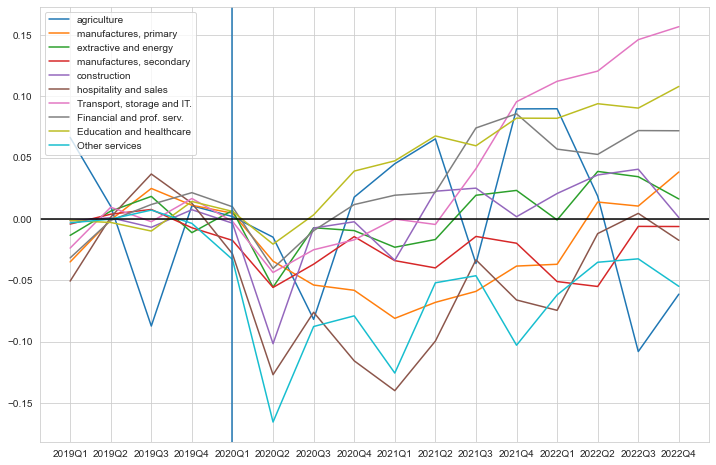

In [113]:
sn.set_palette('tab10',10)
plt.figure(figsize=(12,8))
for ind in industry_dict.values():
    plt.plot(tab_e_ind_change19_rel.loc['2019Q1':,ind],label=ind)
plt.legend()
plt.axvline('2020Q1')
plt.axhline(c='k')
# plt.xticks(tab_e_ind_change19_rel.index['2019Q1'::],rotation=90)
plt.show()

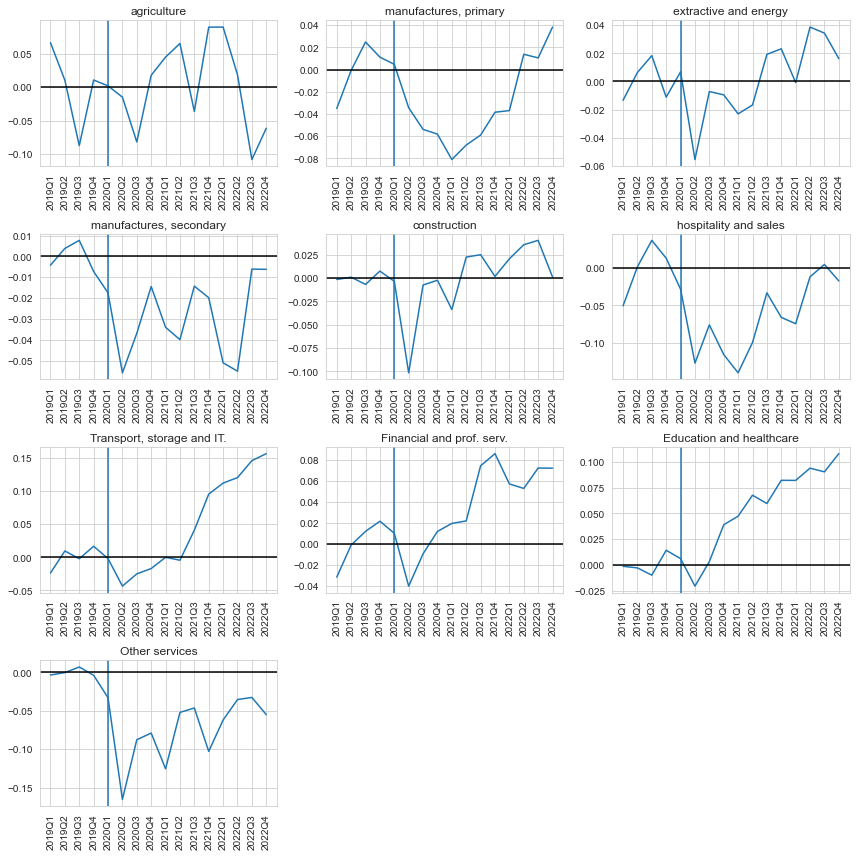

In [121]:
sn.set_palette('tab10',10)
plt.figure(figsize=(12,12))
for i,ind in enumerate(industry_dict.values()):
    plt.subplot(4,3,1+i)
    plt.title(ind)
    plt.plot(tab_e_ind_change19_rel.loc['2019Q1':,ind],label=ind)
# plt.legend()
    plt.axvline('2020Q1')
    plt.axhline(c='k')
    plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

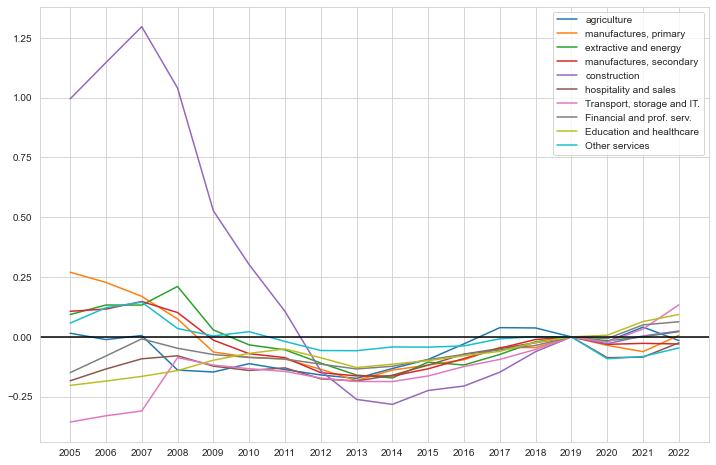

In [132]:
T = 2023-2005
year_changes19 = np.zeros((T,10))
for i,year in enumerate(range(2005,2023)):
    year_changes19[i,:] = np.average(tab_e_ind_change19_rel.loc[str(year)+"Q1":str(year)+"Q4",:],axis=0)
tab_e_ind_change19_rel_y= pd.DataFrame(year_changes19,columns=tab_e_ind_change19_rel.keys(),index=np.arange(2005,2023))

sn.set_palette('tab10',10)
plt.figure(figsize=(12,8))
for ind in industry_dict.values():
    plt.plot(tab_e_ind_change19_rel_y.loc[:,ind],label=ind)
plt.legend()
# plt.axvline('2020Q1')
plt.axhline(c='k')
plt.xticks(np.arange(2005,2023))
plt.show()

In [143]:
from astropy.table import Table
tab = Table.read('./results/qtreg_ind_30340.tex').to_pandas()

In [148]:
tab = tab.set_index('col0')
tab

,"Parents, 25th pctl","Parents, 50th pctl","Parents, 75th pctl"
col0,,,
$t$,$-0.009^{***}$,$-0.004^{***}$,$0.002$
NaN,(0.0006),(0.0015),(0.0016)
$t$ x female,$0.014^{***}$,$0.051^{***}$,$0.033^{***}$
NaN,(0.0010),(0.0022),(0.0021)
unemployment rate x male,$0.027^{***}$,$0.039^{***}$,$-0.003$
...,...,...,...
NaN,(0.3206),(0.5239),(0.3636)
$\beta_0$,$-1.057^*$,$-3.058^{***}$,$-1.068$
NaN,(0.5975),(0.8218),(0.8263)


In [162]:
IoI = []
for idx in tab.index:
    if str(idx)[:10]=="$\delta_{2":
        if idx.split(' x ')[-1]=='female':
            IoI.append(idx)
tab_dummies_f=tab.loc[IoI,:].copy()
tab_dummies_f

,"Parents, 25th pctl","Parents, 50th pctl","Parents, 75th pctl"
col0,,,
$\delta_{2020}$ x Agriculture x female,$-0.461^{***}$,$-1.330^{**}$,$-1.066$
$\delta_{2020}$ x Manifactures prim. x female,$0.465^*$,$0.367$,$0.128$
$\delta_{2020}$ x Extractive + energy x female,$-0.016$,$0.504$,$0.908$
$\delta_{2020}$ x manifuctures sec. x female,$-1.089^{**}$,$-1.743$,$0.574$
$\delta_{2020}$ x Construction x female,$-0.599$,$-3.122^{***}$,$0.165$
$\delta_{2020}$ x Hospitality + Sales x female,$-0.099$,$-0.376$,$1.359$
"$\delta_{2020}$ x Transport, Storage + IT x female",$-1.224^{***}$,$-0.462$,$-0.209$
$\delta_{2020}$ x Financial + porf. serv. x female,$-0.867^{***}$,$-1.064$,$-0.505$
$\delta_{2020}$ x Education + Health x female,$-0.962^{**}$,$-2.408^{***}$,$-0.450^{**}$


In [169]:
pctiles = [25,50,75]

for p in pctiles:
    sig_list = []
    for name in IoI:
        thing = tab_dummies_f.loc[name,'Parents, {}th pctl'.format(p)]
        if thing[-5:] == '***}$':
    #     print(thing[-5:])
            sig_list.append(0.01)
        elif thing[-5:] == '{**}$':
            sig_list.append(0.05)
        elif thing[-4:] == '{*}$':
            sig_list.append(0.1)
        else:
            sig_list.append(1.0)
    tab_dummies_f['sig {}'.format(p)] = np.array(sig_list)

In [176]:
for p in pctiles:
    num_list = []
    for name in IoI:
        thing = tab_dummies_f.loc[name,'Parents, {}th pctl'.format(p)]
        thing = thing.replace('*','').replace('{','').replace('}','').replace('$','').replace('^','')
        num_list.append(thing)
    tab_dummies_f.loc[:,'Parents, {}th pctl'.format(p)] = num_list

In [219]:
indust_list = []
for name in IoI:
    indust_list.append(name.split(' x ')[1])
dic_ind_translate = dict(zip(indust_list[:10],industry_dict.values()))

all_ind_dums = []
all_year_dums = []
for ind in tab_dummies_f.index:
    all_ind_dums.append(dic_ind_translate[ind.split(' x ')[1]])
    all_year_dums.append(int(ind.split(' x ')[0].replace('$\\delta_{','').replace("}$","")))
tab_dummies_f['year'] = all_year_dums
tab_dummies_f['ind'] = all_ind_dums

In [230]:
tab_dummies_f = tab_dummies_f.set_index(['year','ind'])
tab_dummies_f.head()

Parents, 25th pctl Parents, 50th pctl  \
year ind                                                             
2020 agriculture                         -0.461             -1.330   
     manufactures, primary                0.465              0.367   
     extractive and energy               -0.016              0.504   
     manufactures, secondary             -1.089             -1.743   
     construction                        -0.599             -3.122   

                             Parents, 75th pctl  sig 25  sig 50  sig 75  
year ind                                                                 
2020 agriculture                         -1.066    0.01    0.05     1.0  
     manufactures, primary                0.128    1.00    1.00     1.0  
     extractive and energy                0.908    1.00    1.00     1.0  
     manufactures, secondary              0.574    0.05    1.00     1.0  
     construction                         0.165    1.00    0.01     1.0

In [223]:
tab_e_ind_change19_rel_y.head()

,agriculture,"manufactures, primary",extractive and energy,"manufactures, secondary",construction,hospitality and sales,"Transport, storage and IT.",Financial and prof. serv.,Education and healthcare,Other services
2005,0.015279,0.270256,0.093385,0.106997,0.994463,-0.183476,-0.355773,-0.149497,-0.202735,0.057430
2006,-0.011318,0.227566,0.133173,0.116343,1.146313,-0.134152,-0.329611,-0.079718,-0.184701,0.121854
2007,0.005834,0.169494,0.132911,0.147798,1.296175,-0.091566,-0.309594,-0.008250,-0.164981,0.145174
2008,-0.138652,0.074869,0.210751,0.101797,1.039793,-0.078999,-0.086668,-0.047421,-0.140981,0.035112
2009,-0.146693,-0.063117,0.029005,-0.013642,0.526856,-0.122280,-0.117828,-0.073836,-0.097408,0.004156


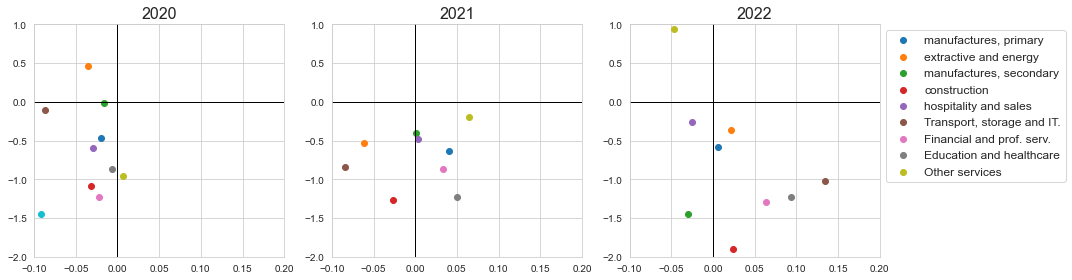

In [273]:
sn.set_palette('tab10',10)
plt.figure(figsize=(15,4))
for i,year in enumerate([2020,2021,2022]):
    plt.subplot(131+i)
    plt.title(year,fontsize=16)
    for ind in tab_dummies_f.loc[year,:].index:
        plt.scatter(tab_e_ind_change19_rel_y.loc[year,ind],
                    float(tab_dummies_f.loc[(year,ind),'Parents, 25th pctl']),label=ind)
    plt.ylim(-2,1)
    plt.xlim(-0.1,0.2)
    plt.axvline(c='k',lw=1)
    plt.axhline(c='k',lw=1)
plt.legend(fontsize=12,bbox_to_anchor=(1.,1))
plt.tight_layout()
plt.show()

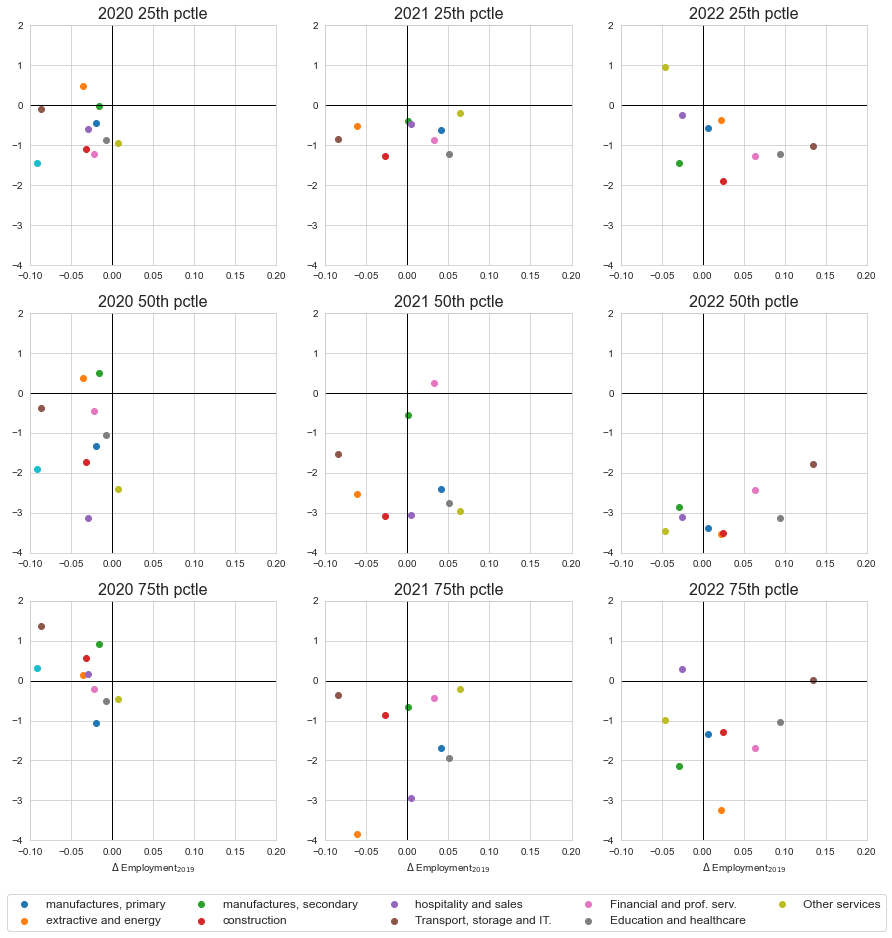

In [292]:
sn.set_palette('tab10',10)
plt.figure(figsize=(15,15))
for j,pct in enumerate([25,50,75]):
    for i,year in enumerate([2020,2021,2022]):
        xx = 331+i+(j*3)
        plt.subplot(xx)
        plt.title(str(year)+" {}th pctle".format(pct),fontsize=16)
        for ind in tab_dummies_f.loc[year,:].index:
            plt.scatter(tab_e_ind_change19_rel_y.loc[year,ind],
                        float(tab_dummies_f.loc[(year,ind),'Parents, {}th pctl'.format(pct)]),label=ind)
        plt.ylim(-4,2)
        plt.xlim(-0.1,0.2)
        plt.axvline(c='k',lw=1)
        plt.axhline(c='k',lw=1)
        if xx >336:
            plt.xlabel(r'$\Delta$ Employment$_{2019}$')
plt.legend(fontsize=12,ncol=5,bbox_to_anchor=(1.1,-0.2))
plt.savefig('./plots_stocks/scatter_indE_mother_penalty.pdf',format='pdf',bbox_inches='tight')
plt.show()